<a href="https://colab.research.google.com/github/mecanalpay/iot/blob/master/VideoK_pos_neg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

IMDB büyük film eleştiri veri kümesi bir ikili sınıflandırma veri kümesi-tüm yorumları pozitif ya da negatif duygular ya olması.

Kullanarak veri kümesini indir TFDS . Bkz yükleme metin öğretici elle veri bu tür yüklemek konusunda detaylar için.

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Başlangıçta bu (metin, etiket çiftleri) bir veri kümesi döndürür:

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Sonraki eğitim için verileri karıştırmak ve bunların oluşturmak partiler (text, label) çiftleri:



In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This is loosely based on the ideas of the original 80\'s hit . It\'s set in the modern day as we see a base in Afghanistan get destroyed by a UAV right at the start.<br /><br />And that\'s exactly where the movie jumps the shark. UAV\'s aren\'t armed. They could be but I don\'t think it\'s ever been tried for real. We get to see the computer that has masterminded this operation, called R.I.P.L.E.Y. We are introduced to "hacker" Will Farmer (he\'s good at chemistry & electronics which doesn\'t make him a computer hacker) & his love interest, Annie) & Will\'s 1st attempt at hacking is not only a complete failure his IP address is also logged and Annie guessed who it was. We also meet Wills mom who works for a chemical company.<br /><br />Wills taking money from his neighbours bank account (Mr Massude) isn\'t a hack (he helped him set up the account), we then get a nod back to the original movie where they decide against playing Global Thermonuclear War & they play The Dead Cod

Metin kodlayıcıyı oluşturun
Tarafından yüklenen ham metin tfds bir modelde kullanılmadan önce işlenmesi gerekir. Eğitim için işlem metne basit yolu kullanıyor TextVectorization katmanı. Bu katmanın birçok yeteneği vardır, ancak bu öğretici varsayılan davranışa bağlıdır.

Katmanı oluşturun ve katmanın için veri kümesinin metin geçmek .adapt yöntemle:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

.adapt yöntem katmanın kelime ayarlar. İşte ilk 20 jeton. Doldurma ve bilinmeyen belirteçlerden sonra, frekansa göre sıralanırlar:

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Sözcük bilgisi ayarlandıktan sonra, katman metni dizinlere kodlayabilir. (Bir sabit set sürece indekslerinin tansörleri toplu uzun dizisine 0-yastıklı output_sequence_length ):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[11,  7,  1, ...,  0,  0,  0],
       [11,  7,  2, ...,  0,  0,  0],
       [ 2,  1,  1, ...,  0,  0,  0]])

Varsayılan ayarlarla, işlem tamamen geri döndürülemez. Bunun üç ana nedeni vardır:

İçin varsayılan değer preprocessing.TextVectorization 'ın standardize argümanı olan "lower_and_strip_punctuation" .
Sınırlı kelime boyutu ve karakter tabanlı geri dönüş eksikliği, bazı bilinmeyen belirteçlere neden olur.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This is loosely based on the ideas of the original 80\'s hit . It\'s set in the modern day as we see a base in Afghanistan get destroyed by a UAV right at the start.<br /><br />And that\'s exactly where the movie jumps the shark. UAV\'s aren\'t armed. They could be but I don\'t think it\'s ever been tried for real. We get to see the computer that has masterminded this operation, called R.I.P.L.E.Y. We are introduced to "hacker" Will Farmer (he\'s good at chemistry & electronics which doesn\'t make him a computer hacker) & his love interest, Annie) & Will\'s 1st attempt at hacking is not only a complete failure his IP address is also logged and Annie guessed who it was. We also meet Wills mom who works for a chemical company.<br /><br />Wills taking money from his neighbours bank account (Mr Massude) isn\'t a hack (he helped him set up the account), we then get a nod back to the original movie where they decide against playing Global Thermonuclear War & they play The Dead C

modeli oluştur

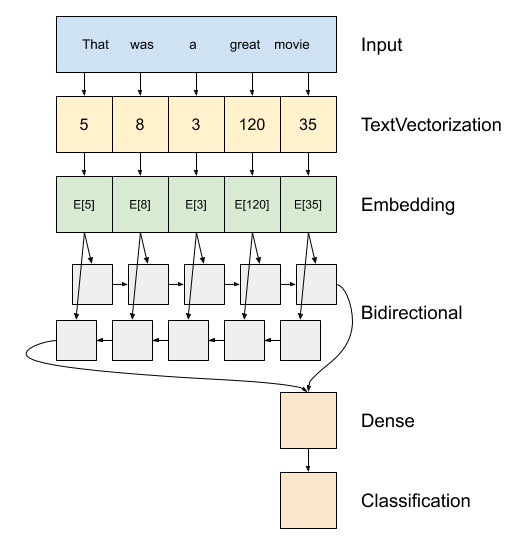

Yukarıdaki modelin bir diyagramıdır.

Bu model olarak inşa olabilir tf.keras.Sequential .

Birinci tabaka encoder belirteç endekslerinin bir sekansa metin dönüştürür.

Kodlayıcıdan sonra bir gömme katmanı bulunur. Bir gömme katmanı, kelime başına bir vektör depolar. Çağrıldığında, kelime dizinlerinin dizilerini vektör dizilerine dönüştürür. Bu vektörler eğitilebilir. Eğitimden sonra (yeterli veri üzerinde), benzer anlamlara sahip kelimeler genellikle benzer vektörlere sahiptir.

Bu indeks-arama çok daha etkili bir ile bir sıcak kodlanmış vektör geçen benzer bir işlem daha tf.keras.layers.Dense tabakası.

Tekrarlayan bir sinir ağı (RNN), öğeler arasında yineleme yaparak dizi girişini işler. RNN'ler, çıktıları bir zaman adımından sonraki zaman adımındaki girdilerine iletir.

tf.keras.layers.Bidirectional sargı ayrıca, bir RYSA tabaka ile birlikte kullanılabilir. Bu, girdiyi RNN katmanı boyunca ileri ve geri yayar ve ardından son çıktıyı birleştirir.

Çift yönlü bir RNN'nin ana avantajı, girişin başlangıcından gelen sinyalin çıkışı etkilemek için her zaman adımında tamamen işlenmesine gerek olmamasıdır.

Çift yönlü bir RNN'nin ana dezavantajı, kelimeler sona eklenirken tahminleri verimli bir şekilde aktaramamanızdır.

RYSA tek bir vektöre dizisi dönüştürülür sonra iki layers.Dense sınıflandırma çıkış olarak tek bir logit için bu vektör gösteriminden bazı son işleme ve dönüştürme yapmak.

Bunu uygulamak için kod aşağıdadır:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Lütfen Keras sıralı modelinin burada kullanıldığını unutmayın, çünkü modeldeki tüm katmanlar yalnızca tek girdiye sahiptir ve tek çıktı üretir. Durum bilgisi olan RNN katmanını kullanmak istemeniz durumunda, RNN katman durumlarını alıp yeniden kullanabilmeniz için modelinizi Keras işlevsel API'si veya model alt sınıflaması ile oluşturmak isteyebilirsiniz. Kontrol edin Keras RYSA rehber daha fazla ayrıntı için.

Gömme tabakası maskeleme kullanımları değişen dizi-uzunlukları işlemek için. Sonra tüm katmanları Embedding destek maskeleme:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Bunun beklendiği gibi çalıştığını doğrulamak için bir cümleyi iki kez değerlendirin. İlk olarak, maskelenecek dolgu olmaması için tek başına:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.00054533]


Şimdi, daha uzun bir cümle ile toplu olarak tekrar değerlendirin. Sonuç aynı olmalıdır:



In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 369ms/step
[-0.00054534]


Eğitim sürecini yapılandırmak için Keras modelini derleyin:



In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Video Kariyer Model Eğitimi**

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 808s 2s/step - loss: 0.6534 - accuracy: 0.5571 - val_loss: 0.5321 - val_accuracy: 0.7042
Epoch 2/10
391/391 [==============================] - 762s 2s/step - loss: 0.4639 - accuracy: 0.7685 - val_loss: 0.4097 - val_accuracy: 0.8219
Epoch 3/10
391/391 [==============================] - 749s 2s/step - loss: 0.3818 - accuracy: 0.8290 - val_loss: 0.3850 - val_accuracy: 0.8396
Epoch 4/10
391/391 [==============================] - 736s 2s/step - loss: 0.3407 - accuracy: 0.8524 - val_loss: 0.3504 - val_accuracy: 0.8323
Epoch 5/10
391/391 [==============================] - 747s 2s/step - loss: 0.3246 - accuracy: 0.8585 - val_loss: 0.3378 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 737s 2s/step - loss: 0.3114 - accuracy: 0.8667 - val_loss: 0.3301 - val_accuracy: 0.8531
Epoch 7/10
391/391 [==============================] - 734s 2s/step - loss: 0.3075 - accuracy: 0.8670 - val_loss: 0.3238 - val_accuracy: 0.8562

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 174s 444ms/step - loss: 0.3145 - accuracy: 0.8598
Test Loss: 0.31450948119163513
Test Accuracy: 0.8598399758338928


In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Yeni bir öz geçmiş üzerinde bir tahmin yürütün:

Tahmin >= 0.0 ise pozitif, aksi halde negatiftir.[bağlantı metni](https://)

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


İki veya daha fazla LSTM katmanını istifleyin
Keras tekrarlayan katmanlar tarafından kontrol edilir mevcut iki modu vardır return_sequences yapıcı argüman:

Eğer False her giriş dizisi için sadece son çıkışı verir (şekil (batch_size bir 2D tensörünün output_features)). Bu, önceki modelde kullanılan varsayılandır.

Eğer True her timestep için ardışık çıkışların tam dizileri (şekil 3B tensörünün döndürülür (batch_size, timesteps, output_features) ).

İşte ne olduğu gibi bilgiler görünüyor akış return_sequences=True :

katmanlı_çift yönlü

Bir kullanımı hakkında ilginç şey RNN ile return_sequences=True böyle, başka RYSA katmanına geçirilebilir böylece verimi hala girişi gibi, 3-eksenleri olmasıdır:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1472s 4s/step - loss: 0.6241 - accuracy: 0.5817 - val_loss: 0.4424 - val_accuracy: 0.7771
Epoch 2/10
391/391 [==============================] - 1440s 4s/step - loss: 0.3747 - accuracy: 0.8355 - val_loss: 0.3489 - val_accuracy: 0.8391
Epoch 3/10
391/391 [==============================] - 1459s 4s/step - loss: 0.3313 - accuracy: 0.8589 - val_loss: 0.3341 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 1440s 4s/step - loss: 0.3181 - accuracy: 0.8646 - val_loss: 0.3332 - val_accuracy: 0.8365
Epoch 5/10
 60/391 [===>..........................] - ETA: 18:59 - loss: 0.3086 - accuracy: 0.8680

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')